In [20]:
#Here you must specify your own path
root = ''

In [21]:
pip install tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow_addons as tfa
from sklearn.metrics import classification_report
from numpy.random import seed
seed(0)
tf.random.set_seed(0)

In [23]:
# Dic to get the respective target values of the numbers.
target_dic = {
    0: '(0, 20]constant',
    1: '(20, 40]constant',
    2: '(40, 60]constant',
    3: '(60, 80]constant',
    4: '(80, 100]constant',
    5: '(0, 20]intermittent',
    6: '(20, 40]intermittent',
    7: '(40, 60]intermittent',
    8: '(60, 80]intermittent',
    9: '(80, 100]intermittent',
}

In [24]:
#Dic to get the class weight of the corresponding class. Computed in Data_split notebook
class_weights = {
    0: 0.35625,
    1: 1.05674157,
    2: 0.69409594,
    3: 0.74642857,
    4: 1.254,
    5: 0.9746114,
    6: 1.69459459,
    7: 1.881,
    8: 2.475,
    9: 8.55,
}

In [25]:
#read in csv file into dataframe
df_train = pd.read_csv(root + 'data/02_processed/completed_train.csv', sep=';')
df_train.pop('Unnamed: 0')

#read validation and test data from csv
df_validation = pd.read_csv(root + 'data/02_processed/completed_validation.csv', sep=';')
df_validation.set_index('user_id',inplace=True)
df_test = pd.read_csv(root + 'data/02_processed/completed_test.csv', sep=';')
df_test.set_index('user_id',inplace=True)
target_testO = df_test['target']
target_test=pd.get_dummies(df_test['target'], prefix='target')

iterator=df_train.copy()
iterator.pop('target')

#Function to transform dataframe into tf.dataset
def df_to_ds(dataframe, shuffle,batch_size):
  dataframe = dataframe.copy()
  target= pd.get_dummies(dataframe['target'], prefix='target')
    
  dataframe.pop('target')
  dataset = tf.data.Dataset.from_tensor_slices((dict(dataframe), target.values))
  if shuffle:
    dataset = dataset.shuffle(buffer_size=len(dataframe))
  dataset = dataset.batch(batch_size)
  return dataset

#Transform into tf dataset with batchsize.
batch_size = 16
train_ds = df_to_ds(df_train,shuffle=True, batch_size=batch_size)
val_ds = df_to_ds(df_validation, shuffle=False, batch_size=batch_size)
test_ds = df_to_ds(df_test, shuffle=False, batch_size=batch_size)

In [26]:
raw_inputs = {}

#Get the categorical and numerical column names
categorical_columns=[]
numerical_columns=[]
for name, values in iterator.iteritems():
    if values.dtype==np.float64:
        numerical_columns.append(name)
    if values.dtype==object:
        categorical_columns.append(name)
        
#creating the inputs for the neural network        
for column_name in categorical_columns:
      raw_inputs[column_name] = tf.keras.Input(shape=(1,), name=column_name, dtype=tf.string)

for column_name in numerical_columns:
    raw_inputs[column_name] = tf.keras.Input(shape=(1,), name=column_name, dtype=tf.float32)
    
raw_inputs

{'5': <KerasTensor: shape=(None, 1) dtype=string (created by layer '5')>,
 '8': <KerasTensor: shape=(None, 1) dtype=string (created by layer '8')>,
 '10': <KerasTensor: shape=(None, 1) dtype=string (created by layer '10')>,
 '11': <KerasTensor: shape=(None, 1) dtype=string (created by layer '11')>,
 '35': <KerasTensor: shape=(None, 1) dtype=string (created by layer '35')>,
 '37': <KerasTensor: shape=(None, 1) dtype=string (created by layer '37')>,
 '40': <KerasTensor: shape=(None, 1) dtype=string (created by layer '40')>,
 '68': <KerasTensor: shape=(None, 1) dtype=string (created by layer '68')>,
 '70': <KerasTensor: shape=(None, 1) dtype=string (created by layer '70')>,
 '71': <KerasTensor: shape=(None, 1) dtype=string (created by layer '71')>,
 '72': <KerasTensor: shape=(None, 1) dtype=string (created by layer '72')>,
 '74': <KerasTensor: shape=(None, 1) dtype=string (created by layer '74')>,
 '76': <KerasTensor: shape=(None, 1) dtype=string (created by layer '76')>,
 '78': <KerasTen

In [27]:
inputs=[]
for name, input in raw_inputs.items():
    if input.dtype == tf.string:
     continue
    inputs.append(input)


In [28]:
for name, input in raw_inputs.items():
 if input.dtype == tf.float32:
  continue

  string_lookup = preprocessing.StringLookup(vocabulary=np.unique(iterator[name]))
  
  x = string_lookup(input)
  inputs.append(x)
  print(inputs)


In [29]:
#model architecture
inputs_cat = keras.layers.Concatenate(axis=1)(inputs)
hidden1 = keras.layers.Dense(256,activation="elu",kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),kernel_initializer='lecun_uniform')(inputs_cat)
hidden2 = keras.layers.Dense(256,activation="elu",kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),kernel_initializer='lecun_uniform')(hidden1)
output = keras.layers.Dense(10,activation="softmax")(hidden2)
model= keras.Model(inputs=raw_inputs,outputs=output)

In [30]:
#compile model
metric= tfa.metrics.F1Score(average='macro',num_classes=10)
loss="categorical_crossentropy"
optimizer=tf.optimizers.Adam(learning_rate=0.001)
model.compile(loss =loss,
                      optimizer = optimizer,
                       metrics=metric)

In [31]:
#if validation loss is increasing the training is stopped.
early_stopping= keras.callbacks.EarlyStopping(patience=10)

#train model
history = model.fit(train_ds,epochs=1000,batch_size=16,
                    callbacks=[early_stopping]
                    ,validation_data=val_ds)
                   

Epoch 1/1000
199/199 [==============================] - 2s 4ms/step - loss: 2.3600 - f1_score: 0.1662 - val_loss: 2.5608 - val_f1_score: 0.0638
Epoch 2/1000
199/199 [==============================] - 1s 3ms/step - loss: 2.2620 - f1_score: 0.1807 - val_loss: 2.2532 - val_f1_score: 0.1460
Epoch 3/1000
199/199 [==============================] - 1s 3ms/step - loss: 2.2243 - f1_score: 0.1851 - val_loss: 2.1693 - val_f1_score: 0.1570
Epoch 4/1000
199/199 [==============================] - 1s 3ms/step - loss: 2.2063 - f1_score: 0.1862 - val_loss: 2.2182 - val_f1_score: 0.1557
Epoch 5/1000
199/199 [==============================] - 1s 3ms/step - loss: 2.1857 - f1_score: 0.1976 - val_loss: 2.1860 - val_f1_score: 0.1587
Epoch 6/1000
199/199 [==============================] - 1s 3ms/step - loss: 2.1688 - f1_score: 0.2021 - val_loss: 2.2758 - val_f1_score: 0.2027
Epoch 7/1000
199/199 [==============================] - 1s 3ms/step - loss: 2.1717 - f1_score: 0.2144 - val_loss: 2.2165 - val_f1_score:

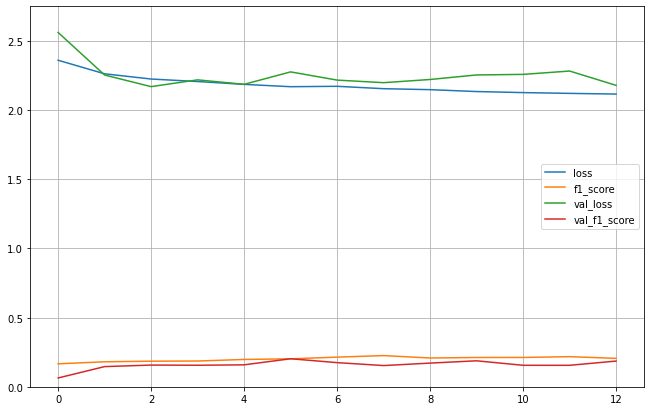

In [32]:
#Visualization of the Training process
pd.DataFrame(history.history).plot(figsize=(11,7))
plt.grid(True)
plt.gca().set_ylim(0,2.75)
plt.show() 

In [33]:
#evaluate model with test dataset
model.evaluate(test_ds)

24/24 [==============================] - 0s 2ms/step - loss: 2.1250 - f1_score: 0.1651


C:\Users\filmo\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\metrics.py:254: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '


[2.124986171722412, 0.1650993674993515]

In [34]:
Predictions = np.argmax(model.predict(test_ds),axis=1)
y_target = np.argmax(target_test.to_numpy(), axis=1)
classes=[0,1,2,3,4,5,6,7,8,9]

In [35]:
# F1-score measured on test data
f1_score(target_testO,Predictions,average='macro')

0.16509937391406712

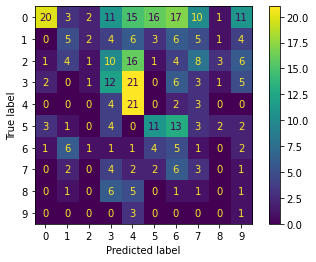

In [36]:
#A confusion matrix of the predictions of the baseline classifier to see how it performs in detail.
c = confusion_matrix(target_testO,pd.Series(Predictions))
cm = ConfusionMatrixDisplay(c).plot()

In [37]:
#classification_report
target_names=['(0, 20]constant','(20, 40]constant','(40, 60]constant','(60, 80]constant','(80, 100]constant','(0, 20]intermittent','(20, 40]intermittent','(40, 60]intermittent','(60, 80]intermittent','(80, 100]intermittent',]
print(classification_report(target_testO,Predictions,digits=3,target_names=target_names,))

                       precision    recall  f1-score   support

      (0, 20]constant      0.741     0.189     0.301       106
     (20, 40]constant      0.227     0.139     0.172        36
     (40, 60]constant      0.143     0.019     0.033        54
     (60, 80]constant      0.214     0.235     0.224        51
    (80, 100]constant      0.233     0.700     0.350        30
  (0, 20]intermittent      0.297     0.282     0.289        39
 (20, 40]intermittent      0.083     0.227     0.122        22
 (40, 60]intermittent      0.081     0.150     0.105        20
 (60, 80]intermittent      0.000     0.000     0.000        15
(80, 100]intermittent      0.030     0.250     0.054         4

             accuracy                          0.210       377
            macro avg      0.205     0.219     0.165       377
         weighted avg      0.338     0.210     0.207       377



In [38]:
print('reached')

reached
